In [ ]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

import maria

m2 = maria.get_array("MUSTANG-2", field_of_view=5, primary_size=10)
daisy_scan = maria.get_pointing("daisy", integration_time=60)
apex_site = maria.get_site("APEX")

from maria.atmosphere import BaseAtmosphericSimulation
from maria import utils
import weathergen
from tqdm import tqdm
import time as ttime

from maria.utils.functions import matern as matern

def get_rotation_matrix_from_skew(x):
    S = x * np.array([[0, 1], [-1, 0]])
    R = sp.linalg.expm(S)
    return R
            
MIN_SAMPLES_PER_RIBBON = 2
JITTER_LEVEL = 1e-6

class SingleLayerSimulation(BaseAtmosphericSimulation):
    """
    The linear angular model treats the atmosphere as a bunch of layers. 

    This model is only appropriate for single instruments, i.e. when the baseline is zero.
    """

    def __init__(self, array, pointing, site, layer_height=1e3, min_beam_res=8, verbose=False, **kwargs):
        super().__init__(array, pointing, site, **kwargs)

        self.min_beam_res = min_beam_res

        self.layer_height = layer_height

        # this is approximately correct
        self.layer_depth = self.layer_height / np.sin(np.mean(self.pointing.el))

        # returns the beam waist for each detector at the layer distance
        self.physical_beam_waists = self.array.get_beam_waist(
            self.layer_height, self.array.primary_size, self.array.dets.band_center.values
        )
        self.angular_beam_waists = self.physical_beam_waists / self.layer_depth

        self.ang_res = self.angular_beam_waists.min() / self.min_beam_res

        self.weather = weathergen.Weather(region=self.site.region, 
                                          altitude=self.site.altitude,
                                          diurnal=True, 
                                          seasonal=True,
                                          levels=np.array([self.site.altitude + self.layer_height]))

        

        self.weather.generate(time=self.pointing.time.mean(), 
                              mode="median", 
                              fixed_quantiles=self.site.weather_quantiles)

        angular_velocity_x = (+self.weather.wind_east[0] * np.cos(self.pointing.az) 
                                   -self.weather.wind_north[0] * np.sin(self.pointing.az)) / self.layer_depth
        
        angular_velocity_y = (-self.weather.wind_east[0] * np.sin(self.pointing.az) 
                                   +self.weather.wind_north[0] * np.cos(self.pointing.az)) / self.layer_depth

        print(angular_velocity_x.shape)
        print(angular_velocity_y.shape)
        
        # compute the offset with respect to the center of the scan
        center_az, center_el = utils.get_center_lonlat(self.pointing.az, self.pointing.el)
        self.pointing.dx, self.pointing.dy = utils.lonlat_to_xy(self.pointing.az, self.pointing.el, center_az, center_el)

        # the angular position of each detector over time WRT the atmosphere
        # this has dimensions (det index, time index)
        self.boresight_angular_position = np.c_[self.pointing.dx + np.cumsum(angular_velocity_x * self.pointing.dt, axis=-1),
                                                self.pointing.dy + np.cumsum(angular_velocity_y * self.pointing.dt, axis=-1)]

        # find the detector offsets which form a convex hull
        self.detector_offsets = np.c_[self.array.sky_x, self.array.sky_y]
        doch = sp.spatial.ConvexHull(self.detector_offsets)
        
        # pad each vertex in the convex hull by an appropriate amount
        unit_circle_angles = np.linspace(0, 2*np.pi, 32+1)[:-1]
        unit_circle_offsets = np.c_[np.cos(unit_circle_angles), np.sin(unit_circle_angles)]
        angular_padding_per_detector = 1.1 * self.angular_beam_waists
        padded_doch_offsets = (angular_padding_per_detector[doch.vertices][:, None, None] * unit_circle_offsets[None, :] 
                               + self.detector_offsets[doch.vertices][:, None]).reshape(-1, 2)
        
        # take the convex hull of those padded vertices
        padded_doch = sp.spatial.ConvexHull(padded_doch_offsets)
        detector_padding = padded_doch_offsets[padded_doch.vertices]
        
        
        # add the padded hull to the moving boresight
        atmosphere_offsets = (detector_padding[:, None] + self.boresight_angular_position[None]).reshape(-1, 2)
        atmosphere_hull = sp.spatial.ConvexHull(atmosphere_offsets)
        self.atmosphere_hull_points = atmosphere_offsets[atmosphere_hull.vertices]


        def optimize_area_minimizing_rotation_matrix(points):        
            def ratio(x):
                R = get_rotation_matrix_from_skew(x[0])
                trans_points = R @ points[..., None]
                log_ratio = np.log(trans_points[:, 0].ptp() / trans_points[:, 1].ptp())
                #print(log_ratio)
                return log_ratio
            
            res = sp.optimize.minimize(ratio, x0=[1.,], tol=1e-16, method="L-BFGS-B")
            return res
        
        # R takes us from the real (dx, dy) to a more compact (cross_section, extrusion) frame
        self.res = optimize_area_minimizing_rotation_matrix(self.atmosphere_hull_points)

        #return
        
        assert self.res.success
        self.R = get_rotation_matrix_from_skew(self.res.x)

        #                   
        #          ^      xxxxxxxxxxxx
        #          |      xxxxxxxxxxxx
        #   cross-section xxxxxxxxxxxx
        #          |      xxxxxxxxxxxx
        #          @      xxxxxxxxxxxx
        #
        
        trans_points = self.atmosphere_hull_points @ self.R.T
        cross_section_min = trans_points[:, 0].min()
        cross_section_max = trans_points[:, 0].max()
        extrusion_min = trans_points[:, 1].min()
        extrusion_max = trans_points[:, 1].max()
        
        self.cross_section_side = np.arange(cross_section_min, cross_section_max + self.ang_res, self.ang_res)
        self.extrusion_side = np.arange(extrusion_min, extrusion_max, self.ang_res)
        
        self.n_cross_section = len(self.cross_section_side)
        self.n_extrusion = len(self.extrusion_side)
        
        CROSS_SECTION, EXTRUSION = np.meshgrid(self.cross_section_side, self.extrusion_side)
        
        self.TRANS_POINTS = np.concatenate([CROSS_SECTION[..., None], EXTRUSION[..., None]], axis=-1)
        
        extrusion_indices = [0, *(2 ** np.arange(0, np.log(self.n_extrusion) / np.log(2))).astype(int), self.n_extrusion-1]
        
        
        
        extrusion_sample_index = []
        cross_section_sample_index = []
        for i, extrusion_index in enumerate(extrusion_indices):
        
            n_ribbon_samples = np.minimum(np.maximum(int(self.n_cross_section * 2 ** -i), MIN_SAMPLES_PER_RIBBON), self.n_cross_section)
            cross_section_indices = np.unique(np.linspace(0, self.n_cross_section - 1, n_ribbon_samples).astype(int))
            cross_section_sample_index.extend(cross_section_indices)
            extrusion_sample_index.extend(np.repeat(extrusion_index, len(cross_section_indices)))

        self.extrusion_sample_index = np.array(extrusion_sample_index)
        self.cross_section_sample_index = np.array(cross_section_sample_index)
        
        live_edge_positions = np.c_[self.cross_section_side, 
                                    np.repeat(extrusion_min - self.ang_res, self.n_cross_section)]
        
        sample_positions = np.c_[CROSS_SECTION[self.extrusion_sample_index, self.cross_section_sample_index], 
                                 EXTRUSION[self.extrusion_sample_index, self.cross_section_sample_index]]
        
        
        # the sampling index will look something like:
        #
        #          x111010000000001 ...
        #          x100000000000000 ...
        #          x110000000000000 ...
        #          x100000000000000 ...
        #  leading x111000000000001 ...
        #  edge    x100000000000000 ...
        #          x110000000000000 ...
        #          x100000000000000 ...
        #          x111000000000001 ...
        #
        
        n_live_edge = len(live_edge_positions)
        n_sample = len(sample_positions)
        
        
        
        outer_scale = 0.1
        
        # sample upper {i,j}
        i, j = np.triu_indices(n_sample, k=1)
        print(len(i))
        COV_S_S = np.eye(n_sample) + JITTER_LEVEL
        COV_S_S[i, j] = matern(np.sqrt(np.square(sample_positions[j] - sample_positions[i]).sum(axis=1)), outer_scale, 5/6)
        COV_S_S[j, i] = COV_S_S[i, j]
        
        # this one is explicit
        COV_LE_S = matern(np.sqrt(np.square(sample_positions[None] - live_edge_positions[:, None]).sum(axis=2)), outer_scale, 5/6)
        
        # live edge upper {i,j}
        i, j = np.triu_indices(n_live_edge, k=1)
        print(len(i))
        COV_LE_LE = np.eye(n_live_edge) + JITTER_LEVEL
        COV_LE_LE[i, j] = matern(np.sqrt(np.square(live_edge_positions[j] - live_edge_positions[i]).sum(axis=1)), outer_scale, 5/6)
        COV_LE_LE[j, i] = COV_LE_LE[i, j]
        
        inv_COV_S_S = maria.utils.fast_psd_inverse(COV_S_S)
        
        self.A = COV_LE_S @ inv_COV_S_S
        self.B = np.linalg.cholesky(COV_LE_LE - self.A @ COV_LE_S.T)
        print(self.A.shape)
        self.VALUES = np.zeros((self.n_extrusion, self.n_cross_section))

        
        
    def extrude(self, n_steps, desc=None):
        # muy rapido
        BUFFER = np.zeros((self.n_extrusion + n_steps, self.n_cross_section))
        BUFFER[self.n_extrusion:] = self.VALUES
        for buffer_index in tqdm(np.arange(n_steps)[::-1], desc=desc):
            
            new_values = self.A @ BUFFER[buffer_index + self.extrusion_sample_index + 1, self.cross_section_sample_index] + self.B @ np.random.standard_normal(size=self.B.shape[-1])
            BUFFER[buffer_index] = new_values
        self.VALUES = BUFFER[:self.n_extrusion]
        

    def simulate_integrated_water_vapor(self):

        self.sim_start = ttime.time()
        self.extrude(n_steps=self.n_extrusion, desc="Generating atmosphere")
        
        #self.extrude(n_steps=0, desc="Initializing atmosphere")


        trans_detector_angular_positions = (self.detector_offsets[:, None] + self.boresight_angular_position[None]) @ self.R.T
        detector_values = np.zeros(trans_detector_angular_positions.shape[:-1])
        for uband in self.array.ubands:
            band_mask = self.array.dets.band == uband
            angular_waist = self.angular_beam_waists[band_mask].mean()
            F = self.array.make_filter(angular_waist, self.ang_res, self.array.beam_func)
            FILTERED_VALUES = self.array.separably_filter(self.VALUES, F) 
            detector_values[band_mask] = sp.interpolate.RegularGridInterpolator((self.cross_section_side, self.extrusion_side), 
                                                                                FILTERED_VALUES.T)(trans_detector_angular_positions[band_mask])

        # this is "zenith-scaled"
        self.effective_integrated_water_vapor = 1. + self.site.pwv_rms * detector_values

        band_passband  = passband[band_mask].mean(axis=0)
        band_passband /= band_passband.sum()
        
        integrated_trj = self.site.spectrum.trj @ band_passband
        trj_interpolator = sp.interpolate.RegularGridInterpolator((self.site.spectrum.side_pwv, self.site.spectrum.side_elevation), integrated_trj)
        
        trj_interpolator((self.effective_integrated_water_vapor, np.degrees(self.EL)))


        self.atm_power = np.zeros(self.effective_integrated_water_vapor.shape)

        with tqdm(total=len(self.array.ubands), desc='Integrating spectra') as prog:
            
            for uband in self.array.ubands:

                band_mask = self.array.dets.band == uband

                #ba_am_trj = (self.am.t_rj * self.array.am_passbands[band_mask].mean(axis=0)[None,None,:]).sum(axis=-1)

                #BA_TRJ_RGI = sp.interpolate.RegularGridInterpolator((self.am.tcwv, np.radians(self.am.elev)), ba_am_trj)

                #self.atm_power[bm] = BA_TRJ_RGI((self.epwv[bm], self.EL[bm]))

                #prog.update(1)

sls = SingleLayerSimulation(array=m2, pointing=daisy_scan, site=apex_site)
sls.simulate_integrated_water_vapor()

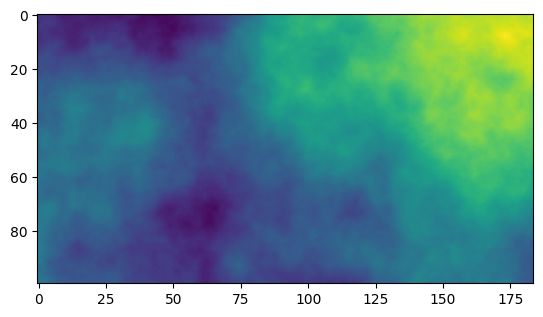

In [96]:
plt.imshow(sls.VALUES[:100])

In [108]:
passband = self.array.passband(self.site.spectrum.nu)

array([[8.10578946, 8.10552109, 8.10524623, ..., 7.99133362, 7.99031111,
        7.98927985],
       [8.07700038, 8.0764816 , 8.07595493, ..., 7.96126614, 7.96037085,
        7.9594721 ],
       [8.13146294, 8.13093517, 8.13038989, ..., 8.0117862 , 8.01070595,
        8.00962358],
       ...,
       [7.87594469, 7.87577833, 7.87559737, ..., 7.70751044, 7.70669145,
        7.70586935],
       [7.90593393, 7.90572133, 7.90550011, ..., 7.72834017, 7.72764153,
        7.72694313],
       [7.93402388, 7.93376184, 7.93349602, ..., 7.7471541 , 7.74640465,
        7.74565285]])

In [132]:
self.effective_integrated_water_vapor.min()

0.9652838851931042

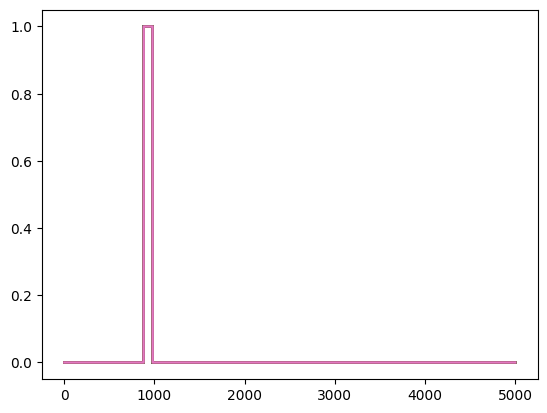

In [136]:
plt.plot(passband.T)
plt.show()

In [111]:
passband @ self.site.spectrum.trj

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 17 is different from 5001)

In [11]:
sls.site.weather_quantiles

{}

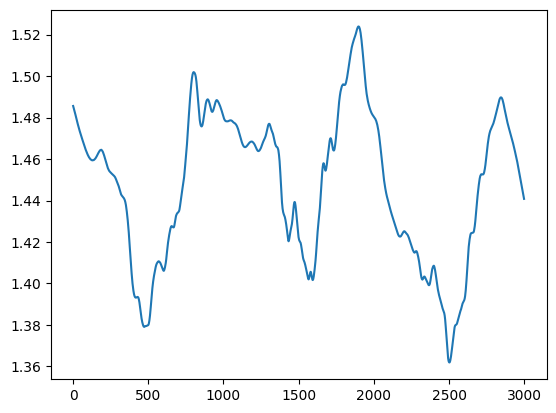

In [92]:
plt.plot(sls.integrated_water_vapor[0])

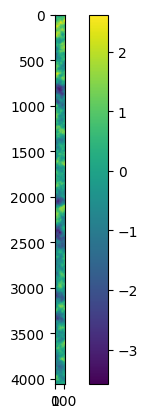

In [30]:
plt.imshow(sls.VALUES[:20000])
plt.colorbar()

In [31]:
self.boresight_angular_position.shape

(30000, 2)

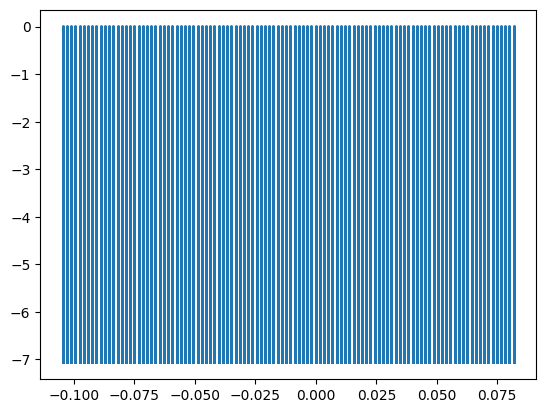

In [33]:
plt.scatter(self.TRANS_POINTS[..., 0], self.TRANS_POINTS[..., 1], s=1)

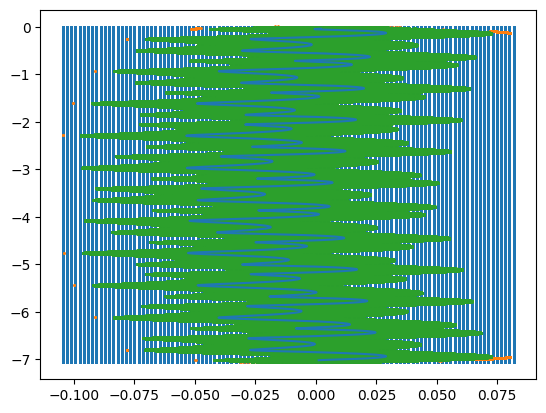

In [58]:
self = sls

trans_boresight_angular_position = self.boresight_angular_position @ self.R.T
trans_points = self.atmosphere_hull_points @ self.R.T

trans_detector_angular_positions = (detector_offsets[:, None] + self.boresight_angular_position[None]) @ self.R.T
detector_values = sp.interpolate.RegularGridInterpolator((self.cross_section_side, self.extrusion_side), self.VALUES.T)(trans_detector_angular_positions)

plt.plot(trans_boresight_angular_position[:,0], trans_boresight_angular_position[:,1])
plt.scatter(self.TRANS_POINTS[..., 0], self.TRANS_POINTS[..., 1], s=1)
plt.scatter(trans_points[..., 0], trans_points[..., 1], s=1)
plt.scatter(trans_detector_angular_positions[..., 0], trans_detector_angular_positions[..., 1], s=1)

#plt.ylim(-8, -7)

In [61]:
trans_detector_angular_positions.min(axis=(0, 1))

array([-0.09698796, -7.05938459])

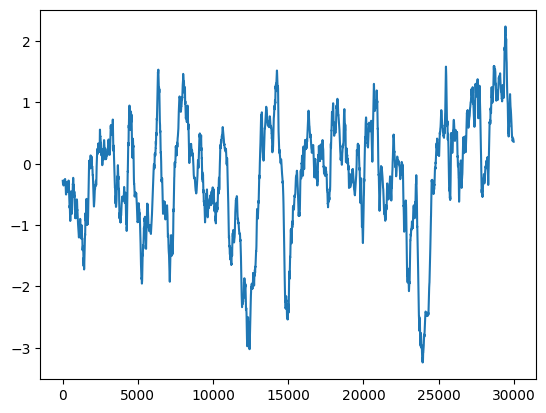

In [73]:
plt.plot(detector_values[2])

In [36]:
self = sls

detector_offsets = np.c_[self.array.sky_x, self.array.sky_y]





In [ ]:
self.boresight_angular_position

In [ ]:
def generate_turbulence):
    

In [21]:
self.VALUES

array([[ 0.25565387,  0.31047088,  0.40684272, ...,  1.1665359 ,
         1.10400757,  1.02390498],
       [ 0.25091871,  0.35430551,  0.36074685, ...,  1.14901612,
         1.07374584,  1.07130228],
       [ 0.28952031,  0.36427959,  0.43307614, ...,  1.12223507,
         1.11134365,  1.04616297],
       ...,
       [ 1.1565091 ,  1.20721716,  1.1809836 , ..., -0.256901  ,
        -0.26527134, -0.31400174],
       [ 1.14410604,  1.12309615,  1.11750721, ..., -0.12871054,
        -0.1663718 , -0.19954952],
       [ 1.17654009,  1.18497294,  1.13280141, ..., -0.0943551 ,
        -0.11227596, -0.13610998]])

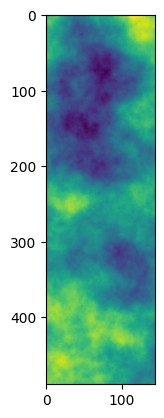

In [23]:
plt.imshow(self.VALUES)

In [439]:
%timeit timestep()

155 ns ± 0.922 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


144
72
36
18
9
5
5
5
5
5
5


In [ ]:
live_edge_cross_section = cross_section_side
live_edge_extrusion = np.repeat(extrusion_min - self.min_ang_res, n_cross_section)

sample_cross_section = CROSS_SECTION[self.extrusion_sample_index, self.cross_section_sample_index]
sample_extrusion = EXTRUSION[self.extrusion_sample_index, self.cross_section_sample_index]

n_live_edge = len(live_edge_extrusion)
n_sample = len(sample_extrusion)

R00 = np.sqrt(np.subtract.outer(X0, X0) ** 2 + np.subtract.outer(Y0, Y0) ** 2)
R01 = np.sqrt(np.subtract.outer(X1, X0) ** 2 + np.subtract.outer(Y1, Y0) ** 2)
R11 = np.sqrt(np.subtract.outer(X1, X1) ** 2 + np.subtract.outer(Y1, Y1) ** 2)

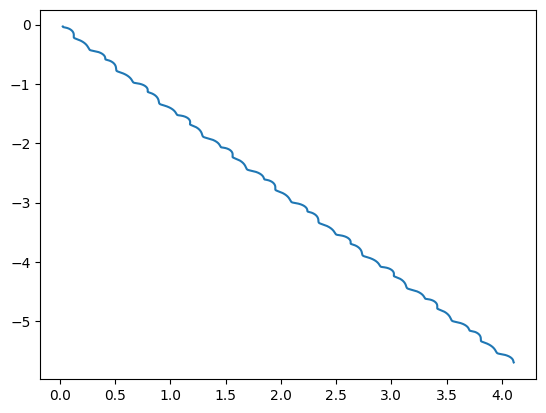

array([0.        , 0.00171485, 0.0034297 , ..., 0.        , 0.06173454,
       0.        ])

In [307]:
matern?

Signature: matern(r, r0, nu)
Docstring: Matern covariance
File:      ~/src/maria/maria/utils/functions.py
Type:      function

In [381]:
for i in range(100):
    new_values = 
    yield np.r_[new_values[None], VALUES[:-1]]

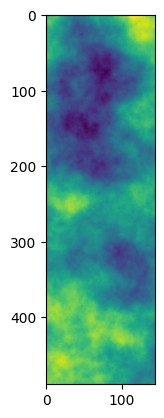

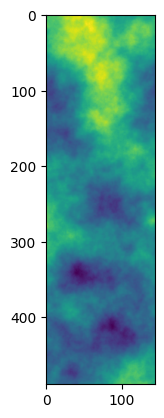

In [382]:
plt.imshow(VALUES)

In [369]:
VALUES[:-1].shape

(488, 144)

In [315]:
matern(np.sqrt(np.square(sample_positions[suj] - sample_positions[sui]).sum(axis=1)), outer_scale, 5/6)

array([0.99831552, 0.99501549, 0.99070257, ..., 0.71701082, 0.44527545,
       0.71701082])

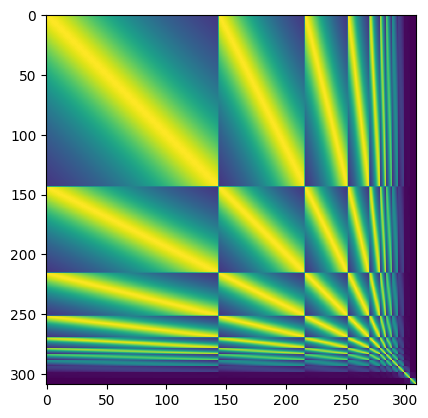

In [317]:
plt.imshow(C00)

(-0.8, -0.7)

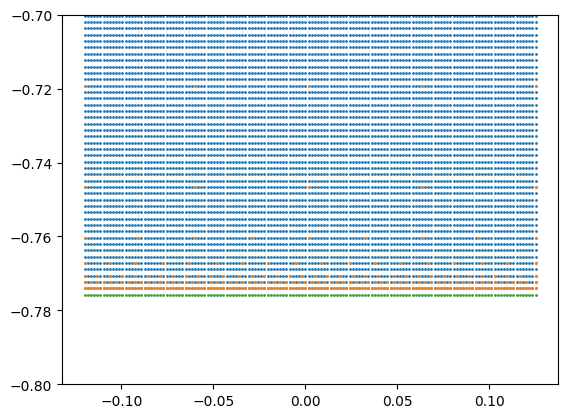

In [291]:
live_edge_cross_section = cross_section_side
live_edge_extrusion = np.repeat(extrusion_min - self.min_ang_res, n_cross_section)

sample_cross_section = CROSS_SECTION[self.extrusion_sample_index, self.cross_section_sample_index]
sample_extrusion = EXTRUSION[self.extrusion_sample_index, self.cross_section_sample_index]

n_live_edge = len(live_edge_extrusion)
n_sample = len(sample_extrusion)

plt.scatter(CROSS_SECTION, EXTRUSION, s=1)
plt.scatter(CROSS_SECTION[self.extrusion_sample_index, self.cross_section_sample_index], 
            EXTRUSION[self.extrusion_sample_index, self.cross_section_sample_index], s=1)
plt.scatter(live_edge_cross_section, live_edge_extrusion, s=1)

plt.ylim(-0.8, -0.7)

In [246]:
#self.cross_section_sample_index

In [231]:
_cross_section_samples

array([  0,   2,   5,   8,  11,  14,  17,  20,  23,  26,  29,  32,  35,
        37,  40,  43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  72,
        75,  78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 107, 110,
       113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143])

In [ ]:
min_anchor_points_per_row = 1

In [184]:
n_trans_x

143

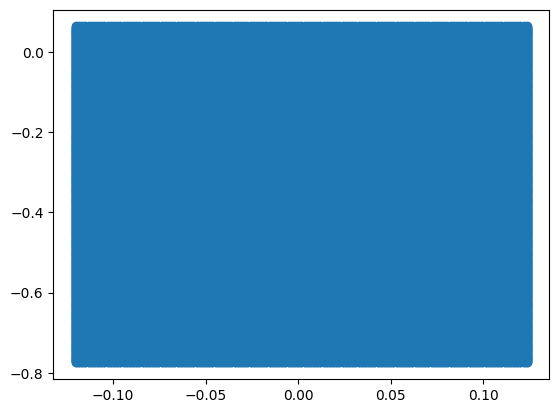

In [185]:
plt.scatter(TRANS_X, TRANS_Y)

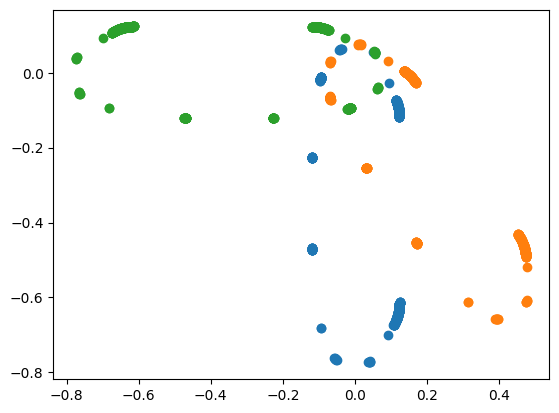

In [155]:
plt.scatter(trans_points[:, 0], trans_points[:, 1])
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(trans_points[:, 1], trans_points[:, 0])

In [ ]:
self.layer_rotation_angles.append(
                utils.get_minimal_bounding_rotation_angle(layer_hull_theta_z.ravel())
            )

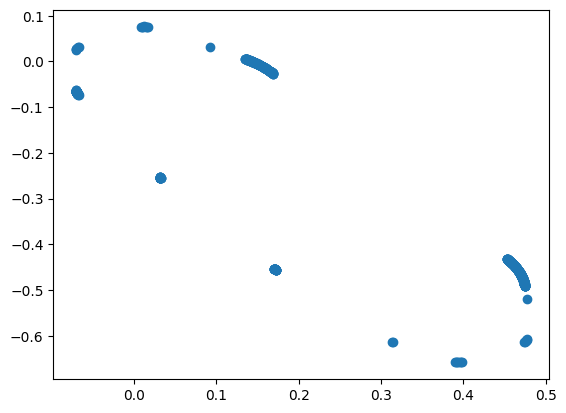

In [53]:
plt.scatter(ahp[:, 0], ahp[:, 1])

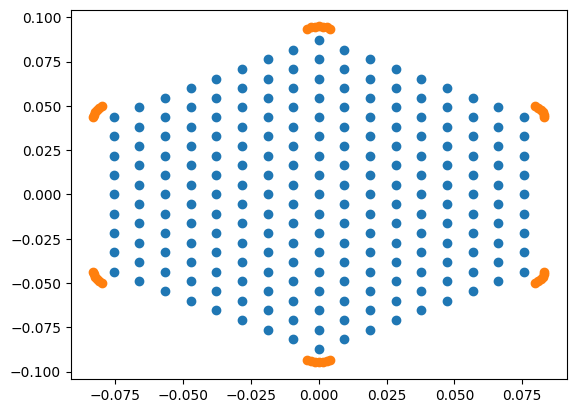

In [25]:
plt.scatter(sls.array.sky_x, sls.array.sky_y)
#plt.plot(*points[hull.vertices].T)
plt.scatter(*padded_doch_offsets[padded_doch.vertices].T)



In [97]:
np.vstack([np.zeros((10, 1000)), np.zeros((10, 1000))]).shape

(20, 1000)

In [100]:
#sls.angular_position

In [98]:
#plt.plot(sls.pointing.dx, sls.pointing.dy)
#plt.plot(sls.angular_position_x[0] - sls.pointing.dx, sls.angular_position_y[0] - sls.pointing.dy)
#plt.show()

In [33]:
import weathergen

apex_site.weather

AttributeError: 'Site' object has no attribute 'weather'

NameError: name 'self' is not defined

'chajnantor'

In [ ]:
self.weather.generate(time=self.pointing.time, mode="median", fixed_quantiles=self.site.weather_quantiles)

AttributeError: 'SingleLayerSimulation' object has no attribute 'layer_depths'